## Hyperparameter

Ce code vient en grande partie de https://borea17.github.io/paper_summaries/iwae. Notre contribution est d'y avoir adapté l'estimateur ML-SS.

In [1]:
MNIST_SIZE = 28
HIDDEN_DIM = 400
LATENT_DIM = 50
BATCH_SIZE = 1000
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-6
SCHEDULER_STEP_SIZE = 50
SCHEDULER_GAMMA = 0.5

## Imports

In [3]:
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.distributions as dists
from matplotlib.gridspec import GridSpec
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from livelossplot import PlotLosses
from prettytable import PrettyTable

## Binarized MNIST Dataset

In [4]:
class Binarized_MNIST(datasets.MNIST):    
    def __init__(self, root, train, transform=None, target_transform=None, download=False):
        super(Binarized_MNIST, self).__init__(root, train, transform, target_transform, download)

    def __getitem__(self, idx):
        img, target = super().__getitem__(idx)
        return dists.Bernoulli(img).sample().type(torch.float32)

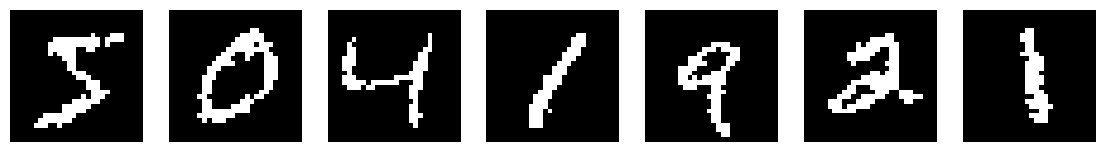

In [5]:
n_samples = 7
binarized_MNIST = Binarized_MNIST('./data', train=True, download=True,
                                  transform=transforms.ToTensor())
plt.figure(figsize=(14, 5))
for i in range(n_samples):
    plt.subplot(1, n_samples, 1 + i)
    plt.imshow(binarized_MNIST[i][0], vmin=0, vmax=1, cmap='gray')
    plt.axis('off')

## Model Implementation

In [6]:
class VAE(nn.Module):
    
    def __init__(self, k):
        super(VAE, self).__init__()
        self.k = k
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(MNIST_SIZE**2, HIDDEN_DIM),
            nn.ReLU(),
            nn.Linear(HIDDEN_DIM, HIDDEN_DIM),
            nn.ReLU(),
            nn.Linear(HIDDEN_DIM, 2*LATENT_DIM)
        )
        self.decoder = nn.Sequential(
            nn.Linear(LATENT_DIM, HIDDEN_DIM),
            nn.ReLU(),
            nn.Linear(HIDDEN_DIM, HIDDEN_DIM),
            nn.ReLU(),
            nn.Linear(HIDDEN_DIM, MNIST_SIZE**2),
            nn.Sigmoid()
        )
        return
    
    def compute_loss(self, x, k=None):
        if not k:
            k = self.k
        [x_tilde, z, mu_z, log_var_z] = self.forward(x, k)
        # upsample x 
        x_s = x.unsqueeze(1).repeat(1, k, 1, 1, 1)
        # compute negative log-likelihood
        NLL = -dists.Bernoulli(x_tilde).log_prob(x_s).sum(axis=(2, 3, 4)).mean()
        # copmute kl divergence
        KL_Div = -0.5*(1 + log_var_z - mu_z.pow(2) - log_var_z.exp()).sum(1).mean()
        # compute loss
        loss = NLL + KL_Div
        return loss
    
    def forward(self, x, k=None):
        """feed image (x) through VAE
        
        Args:
            x (torch tensor): input [batch, img_channels, img_dim, img_dim]
        
        Returns:
            x_tilde (torch tensor): [batch, k, img_channels, img_dim, img_dim]
            z (torch tensor): latent space samples [batch, k, LATENT_DIM]
            mu_z (torch tensor): mean latent space [batch, LATENT_DIM]
            log_var_z (torch tensor): log var latent space [batch, LATENT_DIM] 
        """
        if not k:
            k = self.k
        z, mu_z, log_var_z = self.encode(x, k)
        x_tilde = self.decode(z, k)
        return [x_tilde, z, mu_z, log_var_z]
    
    def encode(self, x, k):
        """computes the approximated posterior distribution parameters and 
        samples from this distribution
        
        Args:
            x (torch tensor): input [batch, img_channels, img_dim, img_dim]
            
        Returns:
            z (torch tensor): latent space samples [batch, k, LATENT_DIM]
            mu_E (torch tensor): mean latent space [batch, LATENT_DIM]
            log_var_E (torch tensor): log var latent space [batch, LATENT_DIM]
        """
        # get encoder distribution parameters
        out_encoder = self.encoder(x)
        mu_E, log_var_E = torch.chunk(out_encoder, 2, dim=1)
        # increase shape for sampling [batch, samples, latent_dim]
        mu_E_ups = mu_E.unsqueeze(1).repeat(1, k, 1)
        log_var_E_ups = log_var_E.unsqueeze(1).repeat(1, k, 1)
        # sample noise variable for each batch and sample
        epsilon = torch.randn_like(log_var_E_ups)
        # get latent variable by reparametrization trick
        z = mu_E_ups + torch.exp(0.5*log_var_E_ups) * epsilon
        return z, mu_E, log_var_E
    
    def decode(self, z, k):
        """computes the Bernoulli mean of p(x|z)
        note that linear automatically parallelizes computation
        
        Args:
            z (torch tensor): latent space samples [batch, k, LATENT_DIM]
        
        Returns:
            x_tilde (torch tensor): [batch, k, img_channels, img_dim, img_dim]
        """
        # get decoder distribution parameters 
        x_tilde = self.decoder(z)  # [batch*samples, MNIST_SIZE**2]      
        # reshape into [batch, samples, 1, MNIST_SIZE, MNIST_SIZE] (input shape)
        x_tilde = x_tilde.view(-1, k, 1, MNIST_SIZE, MNIST_SIZE)
        return x_tilde
    
    def create_latent_traversal(self, image_batch, n_pert, pert_min_max=2, n_latents=5):
        device = image_batch.device
        # initialize images of latent traversal
        images = torch.zeros(n_latents, n_pert, *image_batch.shape[1::])
        # select the latent_dims with lowest variance (most informative)
        [x_tilde, z, mu_z, log_var_z] = self.forward(image_batch)
        i_lats = log_var_z.mean(axis=0).sort()[1][:n_latents]
        # sweep for latent traversal
        sweep = np.linspace(-pert_min_max, pert_min_max, n_pert)
        # take first image and encode
        [z, mu_E, log_var_E] = self.encode(image_batch[0:1], k=1)
        for latent_dim, i_lat in enumerate(i_lats):
            for pertubation_dim, z_replaced in enumerate(sweep):
                z_new = z.detach().clone()
                z_new[0][0][i_lat] = z_replaced

                img_rec = self.decode(z_new.to(device), k=1).squeeze(0)
                img_rec = img_rec[0].clamp(0, 1).cpu()

                images[latent_dim][pertubation_dim] = img_rec
        return images
    
    def compute_marginal_log_likelihood(self, x, k=None):
        """computes the marginal log-likelihood in which the sampling
        distribution is exchanged to q_{\phi} (z|x),
        this function can also be used for the IWAE loss computation 
        
        Args:
            x (torch tensor): images [batch, img_channels, img_dim, img_dim]
            
        Returns:
            log_marginal_likelihood (torch tensor): scalar
            log_w (torch tensor): unnormalized log importance weights [batch, k]
        """
        if not k:
            k = self.k
        [x_tilde, z, mu_z, log_var_z] = self.forward(x, k)
        # upsample mu_z, std_z, x_s
        mu_z_s = mu_z.unsqueeze(1).repeat(1, k, 1)
        std_z_s = (0.5 * log_var_z).exp().unsqueeze(1).repeat(1, k, 1)
        x_s = x.unsqueeze(1).repeat(1, k, 1, 1, 1)
        # compute logarithmic unnormalized importance weights [batch, k]       
        log_p_x_g_z = dists.Bernoulli(x_tilde).log_prob(x_s).sum(axis=(2, 3, 4))
        log_prior_z = dists.Normal(0, 1).log_prob(z).sum(2)
        log_q_z_g_x = dists.Normal(mu_z_s, std_z_s).log_prob(z).sum(2)
        log_w = log_p_x_g_z + log_prior_z - log_q_z_g_x
        # compute marginal log-likelihood        
        log_marginal_likelihood = (torch.logsumexp(log_w, 1) -  np.log(k)).mean()
        return log_marginal_likelihood, log_w

In [7]:
class IWAE(VAE):
    
    def __init__(self, k):
        super(IWAE, self).__init__(k)
        return
    
    def compute_loss(self, x, k=None, mode='fast'):
        if not k:
            k = self.k
        # compute unnormalized importance weights in log_units
        log_likelihood, log_w = self.compute_marginal_log_likelihood(x, k)
        # loss computation (several ways possible)
        if mode == 'original':
            ####################### ORIGINAL IMPLEMENTAION #######################
            # numerical stability (found in original implementation)
            log_w_minus_max = log_w - log_w.max(1, keepdim=True)[0]
            # compute normalized importance weights (no gradient)
            w = log_w_minus_max.exp()
            w_tilde = (w / w.sum(axis=1, keepdim=True)).detach()
            # compute loss (negative IWAE objective)
            loss = -(w_tilde * log_w).sum(1).mean()
        elif mode == 'normalized weights':
            ######################## LOG-NORMALIZED TRICK ########################
            # copmute normalized importance weights (no gradient)
            log_w_tilde = log_w - torch.logsumexp(log_w, dim=1, keepdim=True)
            w_tilde = log_w_tilde.exp().detach()
            # compute loss (negative IWAE objective)
            loss = -(w_tilde * log_w).sum(1).mean()
        elif mode == 'fast':
            ########################## SIMPLE AND FAST ###########################
            loss = -log_likelihood
        return loss

In [39]:
class MLMC(IWAE):
    
    def __init__(self, k):
        super(IWAE, self).__init__(k)
        return
    def forward(self, x, k=None):
        """feed image (x) through VAE
        
        Args:
            x (torch tensor): input [batch, img_channels, img_dim, img_dim]
        
        Returns:
            x_tilde (torch tensor): [batch, k, img_channels, img_dim, img_dim]
            z (torch tensor): latent space samples [batch, k, LATENT_DIM]
            mu_z (torch tensor): mean latent space [batch, LATENT_DIM]
            log_var_z (torch tensor): log var latent space [batch, LATENT_DIM] 
        """
        if not k:
            k = self.k
        z, mu_z, log_var_z = self.encode(x, k)
        x_tilde = self.decode(z, k)
        permutation = torch.randperm(z.size(0))
        if z.size(0)//2 != 0:
          z_E,z_O = torch.split(z[permutation],z.size(0)//2)
          mu_z_E,mu_z_O = torch.split(mu_z[permutation],z.size(0)//2)
          log_var_z_E,log_var_z_O = torch.split(log_var_z[permutation],z.size(0)//2)
          x_tilde_E,x_tilde_O  = torch.split(x_tilde[permutation],z.size(0)//2)
          x_E,x_O  = torch.split(x[permutation],z.size(0)//2)
        else : 
          z_E,z_O = z,z
          mu_z_E,mu_z_O = mu_z,mu_z
          log_var_z_E,log_var_z_O = log_var_z,log_var_z
          x_tilde_E,x_tilde_O  = x_tilde,x_tilde
          x_E,x_O  = x,x
        return [x_E,x_O,x_tilde,x_tilde_E,x_tilde_O, z, mu_z, log_var_z,z_E, mu_z_E, log_var_z_E,z_O, mu_z_O, log_var_z_O]
    def compute_marginal_log_likelihood(self, x, k=None):
        """computes the marginal log-likelihood in which the sampling
        distribution is exchanged to q_{\phi} (z|x),
        this function can also be used for the IWAE loss computation 
        
        Args:
            x (torch tensor): images [batch, img_channels, img_dim, img_dim]
            
        Returns:
            log_marginal_likelihood (torch tensor): scalar
            log_w (torch tensor): unnormalized log importance weights [batch, k]
        """
        if not k:
            k = self.k
        [x_E,x_O,x_tilde, x_tilde_E,x_tilde_O,z, mu_z, log_var_z,z_E, mu_z_E, log_var_z_E,z_O, mu_z_O, log_var_z_O] = self.forward(x, k)
        #SPLIT Z IN HALF
        # upsample mu_z, std_z, x_s
        mu_z_s = mu_z.unsqueeze(1).repeat(1, k, 1)
        std_z_s = (0.5 * log_var_z).exp().unsqueeze(1).repeat(1, k, 1)
        mu_z_s_E = mu_z_E.unsqueeze(1).repeat(1, k, 1)
        std_z_s_E = (0.5 * log_var_z_E).exp().unsqueeze(1).repeat(1, k, 1)
        mu_z_s_O = mu_z_O.unsqueeze(1).repeat(1, k, 1)
        std_z_s_O = (0.5 * log_var_z_O).exp().unsqueeze(1).repeat(1, k, 1)
        x_s = x.unsqueeze(1).repeat(1, k, 1, 1, 1)
        x_s_E = x_E.unsqueeze(1).repeat(1, k, 1, 1, 1)
        x_s_O = x_O.unsqueeze(1).repeat(1, k, 1, 1, 1)
        # compute logarithmic unnormalized importance weights [batch, k]       
        log_p_x_g_z = dists.Bernoulli(x_tilde).log_prob(x_s).sum(axis=(2, 3, 4))
        log_p_x_g_z_E = dists.Bernoulli(x_tilde_E).log_prob(x_s_E).sum(axis=(2, 3, 4))
        log_p_x_g_z_O = dists.Bernoulli(x_tilde_O).log_prob(x_s_O).sum(axis=(2, 3, 4))
        log_prior_z_E = dists.Normal(0, 1).log_prob(z_E).sum(2)
        log_q_z_g_x_E = dists.Normal(mu_z_s_E, std_z_s_E).log_prob(z_E).sum(2)
        log_w_E = log_p_x_g_z_E + log_prior_z_E - log_q_z_g_x_E
        log_prior_z_O = dists.Normal(0, 1).log_prob(z_O).sum(2)
        log_q_z_g_x_O = dists.Normal(mu_z_s_O, std_z_s_O).log_prob(z_O).sum(2)
        log_w_O = log_p_x_g_z_O + log_prior_z_O - log_q_z_g_x_O
        log_prior_z = dists.Normal(0, 1).log_prob(z).sum(2)
        log_q_z_g_x = dists.Normal(mu_z_s, std_z_s).log_prob(z).sum(2)
        log_w = log_p_x_g_z + log_prior_z - log_q_z_g_x
        # compute marginal log-likelihood        
        log_marginal_likelihood = (torch.logsumexp(log_w, 1) -  np.log(k)).mean()
        log_marginal_likelihood_E = (torch.logsumexp(log_w_E, 1) -  np.log(k/2)).mean()
        log_marginal_likelihood_O = (torch.logsumexp(log_w_O, 1) -  np.log(k/2)).mean()
        delta_k = log_marginal_likelihood-0.5*(log_marginal_likelihood_E + log_marginal_likelihood_O)
        I0 = log_w.mean()
        # probk = ((1-0.1)**k)*0.1
        probk = 1
        return I0+delta_k/probk, log_w
    def create_latent_traversal(self, image_batch, n_pert, pert_min_max=2, n_latents=5):
        device = image_batch.device
        # initialize images of latent traversal
        images = torch.zeros(n_latents, n_pert, *image_batch.shape[1::])
        # select the latent_dims with lowest variance (most informative)
        [x_E,x_O,x_tilde, x_tilde_E,x_tilde_O,z, mu_z, log_var_z,z_E, mu_z_E, log_var_z_E,z_O, mu_z_O, log_var_z_O] = self.forward(image_batch)
        i_lats = log_var_z.mean(axis=0).sort()[1][:n_latents]
        # sweep for latent traversal
        sweep = np.linspace(-pert_min_max, pert_min_max, n_pert)
        # take first image and encode
        [z, mu_E, log_var_E] = self.encode(image_batch[0:1], k=1)
        for latent_dim, i_lat in enumerate(i_lats):
            for pertubation_dim, z_replaced in enumerate(sweep):
                z_new = z.detach().clone()
                z_new[0][0][i_lat] = z_replaced

                img_rec = self.decode(z_new.to(device), k=1).squeeze(0)
                img_rec = img_rec[0].clamp(0, 1).cpu()

                images[latent_dim][pertubation_dim] = img_rec
        return images

In [9]:
#Proposal = q(z|x), unnormalized_target = p(x,z), probability_mass = p(k), sampler est une fonction qui sample depuis q
#Par exemple : probability_mass= pdf_geometrique, proposal = pdf_normal, sampler= np.random.normal(...)
def SS(proposal, unnormalized_target,probability_mass,sampler):
    #Step 1 : sample K (inversion)
    u = np.random.uniform()
    S=0
    K=0
    while S < u:
        S+=probability_mass(K)
        K+=1
    #Step 2 : Sample Zi, compute log wi
    Z_E = []
    Z= []
    Z_O = []
    log_w = []
    log_w_E= []
    log_w_O = []
    for i in range (2**(K+1)):
        Zi = sampler()
        if i%2==0:
            log_wi = np.log(unnormalized_target())/proposal(Zi)
            Z_E.append(Zi)
            Z.append(Zi)
            log_w_E.append(log_wi)
        else:
            Z_O.append(Zi)
            Z.append(Zi)
            log_wi = np.log(unnormalized_target(Zi))/proposal(Zi)
            log_w_E.append(log_wi)
        log_w.append(log_wi)
    #Step 3 : I0
    I0 = np.mean(log_w)
    #Step 4 : Even and odd likelihood estimator
    # l_E = np.log(np.mean(np.exp(np.array(log_w_E))))
    # l_O = np.log(np.mean(np.exp(np.array(log_w_O))))
    l_E = torch.logsumexp(log_w_E)
    l_O = torch.logsumexp(log_w_O)
    #Step 5 : union estimator
    # l_total = np.log(np.mean(np.exp(np.array(log_w))))
    l_total = torch.logsumexp(log_w)
    #Step 6 : delta k
    delta_k = l_total - 0.5*(l_E+l_O)
    return I0+ delta_k/probability_mass(K)

def RR(proposal, unnormalized_target,probability_mass,sampler):
    #Step 1 : sample K (inversion)
    u = np.random.uniform()
    S=0
    K=0
    while S < u:
        S+=probability_mass(K)
        K+=1
    #Step 2 : Sample Zi, compute log wi
    somme = 0
    for k in range(K+1):
        Z_E = []
        Z= []
        Z_O = []
        log_w = []
        log_w_E= []
        log_w_O = []
        for i in range (2**(k+1)):
            Zi = sampler()
            if i%2==0:
                log_wi = np.log(unnormalized_target())/proposal(Zi)
                Z_E.append(Zi)
                Z.append(Zi)
                log_w_E.append(log_wi)
            else:
                Z_O.append(Zi)
                Z.append(Zi)
                log_wi = np.log(unnormalized_target(Zi))/proposal(Zi)
                log_w_E.append(log_wi)
            log_w.append(log_wi)

        #Step 4 : Even and odd likelihood estimator
        # l_E = np.log(np.mean(np.exp(np.array(log_w_E))))
        # l_O = np.log(np.mean(np.exp(np.array(log_w_O))))
        l_E = torch.logsumexp(log_w_E)
        l_O = torch.logsumexp(log_w_O)
        #Step 5 : union estimator
        # l_total = np.log(np.mean(np.exp(np.array(log_w))))
        l_total = torch.logsumexp(log_w)
        #Step 6 : delta k
        delta_k = l_total - 0.5*(l_E+l_O)
        somme += delta_k/(1-np.sum([probability_mass(i) for i in range(k)]))
    #Step 3 : I0
    I0 = np.mean(log_w)
    return I0+ somme

## Training

In [10]:
def train(dataset, vae_model, iwae_model,mlmc_model, num_epochs):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print('Device: {}'.format(device))
    
    data_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, 
                             num_workers=0)
    vae_model.to(device)
    iwae_model.to(device)
    mlmc_model.to(device)
    
    optimizer_vae = torch.optim.Adam(vae_model.parameters(), lr=LEARNING_RATE,
                                     weight_decay=WEIGHT_DECAY)
    optimizer_iwae = torch.optim.Adam(iwae_model.parameters(), lr=LEARNING_RATE,
                                     weight_decay=WEIGHT_DECAY)
    optimizer_mlmc = torch.optim.Adam(mlmc_model.parameters(), lr=LEARNING_RATE,
                                     weight_decay=WEIGHT_DECAY)
    scheduler_vae = torch.optim.lr_scheduler.StepLR(optimizer_vae, 
                                                    step_size=SCHEDULER_STEP_SIZE, 
                                                    gamma=SCHEDULER_GAMMA)
    scheduler_iwae = torch.optim.lr_scheduler.StepLR(optimizer_iwae, 
                                                     step_size=SCHEDULER_STEP_SIZE, 
                                                     gamma=SCHEDULER_GAMMA)
    scheduler_mlmc = torch.optim.lr_scheduler.StepLR(optimizer_mlmc, 
                                                     step_size=SCHEDULER_STEP_SIZE, 
                                                     gamma=SCHEDULER_GAMMA)
    losses_plot = PlotLosses(groups={'Loss': ['VAE (ELBO)', 'IWAE (NLL)',"MLMC (NLL)"]})
    for epoch in range(1, num_epochs + 1):
        avg_NLL_VAE, avg_NLL_IWAE , avg_NLL_MLMC= 0, 0,0
        for x in data_loader:
            x = x.to(device)
            # IWAE update
            optimizer_iwae.zero_grad()
            loss = iwae_model.compute_loss(x)
            loss.backward()
            optimizer_iwae.step()
            avg_NLL_IWAE += loss.item() / len(data_loader)
            
            # VAE update
            optimizer_vae.zero_grad()
            loss= vae_model.compute_loss(x)
            loss.backward()
            optimizer_vae.step()
            
            avg_NLL_VAE += loss.item() / len(data_loader)
            # MLMC update
            optimizer_mlmc.zero_grad()
            loss = mlmc_model.compute_loss(x)
            loss.backward()
            optimizer_mlmc.step()
            avg_NLL_MLMC += loss.item() / len(data_loader)
        # step schedulers
        scheduler_iwae.step()
        scheduler_vae.step()
        scheduler_mlmc.step()
        # plot current losses
        losses_plot.update({'VAE (ELBO)': avg_NLL_VAE, 'IWAE (NLL)': avg_NLL_IWAE,"MLMC (NLL)":avg_NLL_MLMC}, 
                           current_step=epoch)
        losses_plot.send()
    trained_vae, trained_iwae, trained_mlmc = vae_model, iwae_model, mlmc_model
    return trained_vae, trained_iwae, trained_mlmc

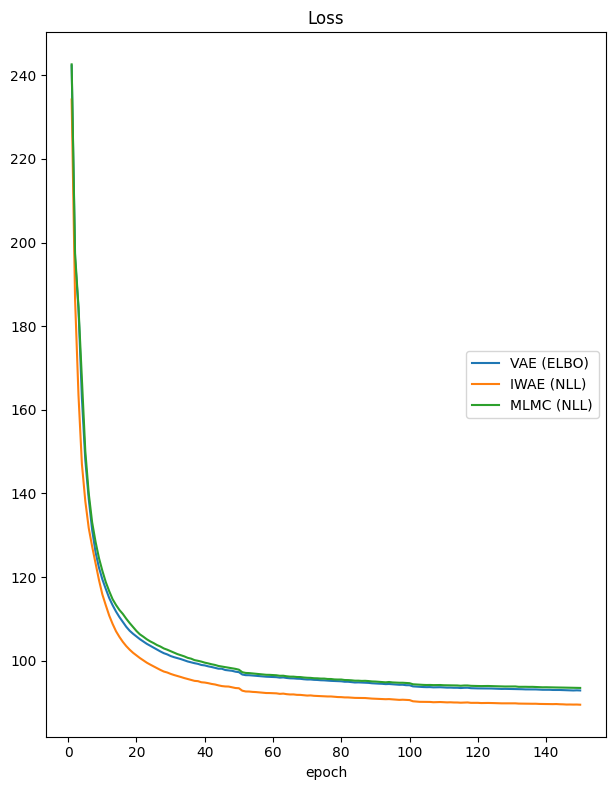

Loss
	VAE (ELBO)       	 (min:   92.902, max:  242.328, cur:   92.904)
	IWAE (NLL)       	 (min:   89.499, max:  234.200, cur:   89.499)
	MLMC (NLL)       	 (min:   93.509, max:  242.602, cur:   93.509)


In [11]:
binarized_MNIST = Binarized_MNIST('./data', train=True, download=True,
                                  transform=transforms.ToTensor())
num_epochs = 150
list_of_ks = [1, 10]

for k in list_of_ks:
    vae_model = VAE(k)
    iwae_model = IWAE(k)
    mlmc_model = MLMC(k)
    trained_vae, trained_iwae, trained_mlmc = train(binarized_MNIST, vae_model, iwae_model,mlmc_model, num_epochs)
    torch.save(trained_vae, f'trained_vae_{k}.pth')
    torch.save(trained_iwae, f'trained_iwae_{k}.pth')
    torch.save(trained_mlmc, f'trained_mlmc_{k}.pth')

## Results

In [14]:
def compute_test_log_likelihood(test_dataset, trained_vae, trained_iwae,trained_mlmc, k=200):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    data_loader = DataLoader(test_dataset, batch_size=20, 
                             shuffle=True, num_workers=12)
    trained_vae.to(device)
    trained_iwae.to(device)
    trained_mlmc.to(device)
    
    avg_marginal_ll_VAE = 0
    avg_marginal_ll_IWAE = 0
    avg_marginal_ll_MLMC = 0
    for x in data_loader:
        marginal_ll, _ = trained_vae.compute_marginal_log_likelihood(x.to(device), k)
        avg_marginal_ll_VAE += marginal_ll.item() / len(data_loader)
        
        marginal_ll, _ = trained_iwae.compute_marginal_log_likelihood(x.to(device), k)
        avg_marginal_ll_IWAE += marginal_ll.item() / len(data_loader)

        marginal_ll, _ = trained_mlmc.compute_marginal_log_likelihood(x.to(device), k)
        avg_marginal_ll_MLMC += marginal_ll.item() / len(data_loader)
    return avg_marginal_ll_VAE, avg_marginal_ll_IWAE, avg_marginal_ll_MLMC


out_table = PrettyTable(["k", "VAE", "IWAE","MLMC"])
test_ds = Binarized_MNIST('./data', train=False, download=True,
                                  transform=transforms.ToTensor())
for k in list_of_ks:
    # load models
    trained_vae = torch.load(f'trained_vae_{k}.pth')
    trained_iwae = torch.load(f'trained_iwae_{k}.pth')
    trained_mlmc = torch.load(f'trained_mlmc_{k}.pth')
    # compute average marginal log-likelihood on test dataset
    ll_VAE, ll_IWAE, ll_MLMC = compute_test_log_likelihood(test_ds, trained_vae, trained_iwae,trained_mlmc)
    out_table.add_row([k, np.round(ll_VAE, 2), np.round(ll_IWAE, 2), np.round(ll_MLMC, 2)])
print(out_table)

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


+----+--------+--------+--------+
| k  |  VAE   |  IWAE  |  MLMC  |
+----+--------+--------+--------+
| 1  | -90.66 | -90.88 | -95.45 |
| 10 | -89.88 | -88.1  | -94.15 |
+----+--------+--------+--------+


## Visualizations

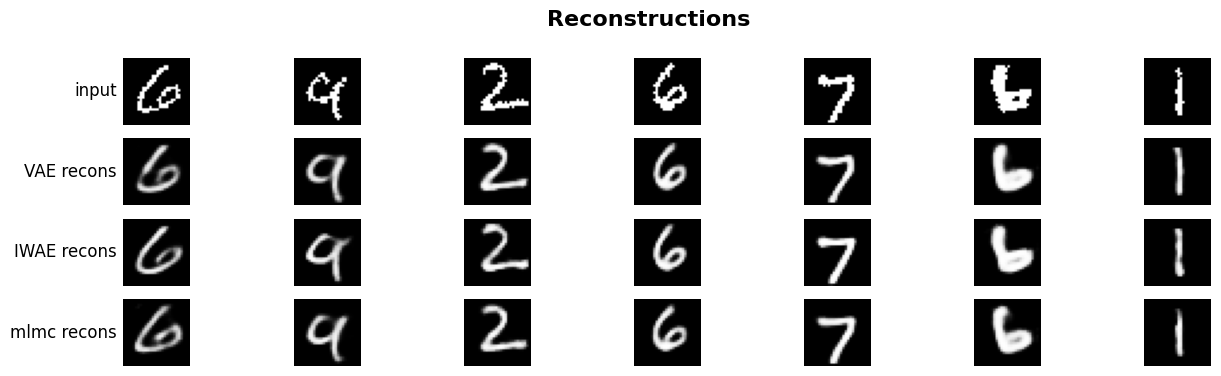

In [36]:
def plot_reconstructions(vae_model, iwae_model, mlmc_model, dataset, SEED=1):
    np.random.seed(SEED)
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    vae_model.to(device)
    iwae_model.to(device)
    mlmc_model.to(device)
    
    n_samples = 7
    i_samples = np.random.choice(range(len(dataset)), n_samples, replace=False)
    
    fig = plt.figure(figsize=(15, 4))
    plt.suptitle("Reconstructions", fontsize=16, y=1, fontweight='bold')
    for counter, i_sample in enumerate(i_samples):
        orig_img = dataset[i_sample]
        # plot original img
        ax = plt.subplot(4, n_samples, 1 + counter)
        plt.imshow(orig_img[0], vmin=0, vmax=1, cmap='gray')
        plt.axis('off')
        if counter == 0:
            ax.annotate("input", xy=(-0.1, 0.5), xycoords="axes fraction",
                        va="center", ha="right", fontsize=12)
        # plot img reconstruction VAE
        [x_tilde, z, mu_z, log_var_z] = vae_model(orig_img.unsqueeze(0).to(device))
        ax = plt.subplot(4, n_samples, 1 + counter + n_samples)
        x_tilde = x_tilde.squeeze(0)[0].detach().cpu().numpy()
        plt.imshow(x_tilde[0], vmin=0, vmax=1, cmap='gray')
        plt.axis('off')
        if counter == 0:
            ax.annotate("VAE recons", xy=(-0.1, 0.5), xycoords="axes fraction",
                        va="center", ha="right", fontsize=12)
        # plot img reconstruction IWAE
        [x_tilde, z, mu_z, log_var_z] = iwae_model(orig_img.unsqueeze(0).to(device))
        ax = plt.subplot(4, n_samples, 1 + counter + 2*n_samples)
        x_tilde = x_tilde.squeeze(0)[0].detach().cpu().numpy()
        plt.imshow(x_tilde[0], vmin=0, vmax=1, cmap='gray')
        plt.axis('off')
        if counter == 0:
            ax.annotate("IWAE recons", xy=(-0.1, 0.5), xycoords="axes fraction",
                        va="center", ha="right", fontsize=12)
        # plot img reconstruction MLMC
        [x_E,x_O,x_tilde, x_tilde_E,x_tilde_O,z, mu_z, log_var_z,z_E, mu_z_E, log_var_z_E,z_O, mu_z_O, log_var_z_O] = mlmc_model(orig_img.unsqueeze(0).to(device))
        ax = plt.subplot(4, n_samples, 1 + counter + 3*n_samples)
        x_tilde = x_tilde.squeeze(0)[0].detach().cpu().numpy()
        plt.imshow(x_tilde[0], vmin=0, vmax=1, cmap='gray')
        plt.axis('off')
        if counter == 0:
            ax.annotate("mlmc recons", xy=(-0.1, 0.5), xycoords="axes fraction",
                        va="center", ha="right", fontsize=12)
    return


k = 10
trained_vae = torch.load(f'trained_vae_{k}.pth')
trained_iwae = torch.load(f'trained_iwae_{k}.pth')
trained_mlmc = torch.load(f'trained_mlmc_{k}.pth')
plot_reconstructions(trained_vae, trained_iwae , trained_mlmc,test_ds)

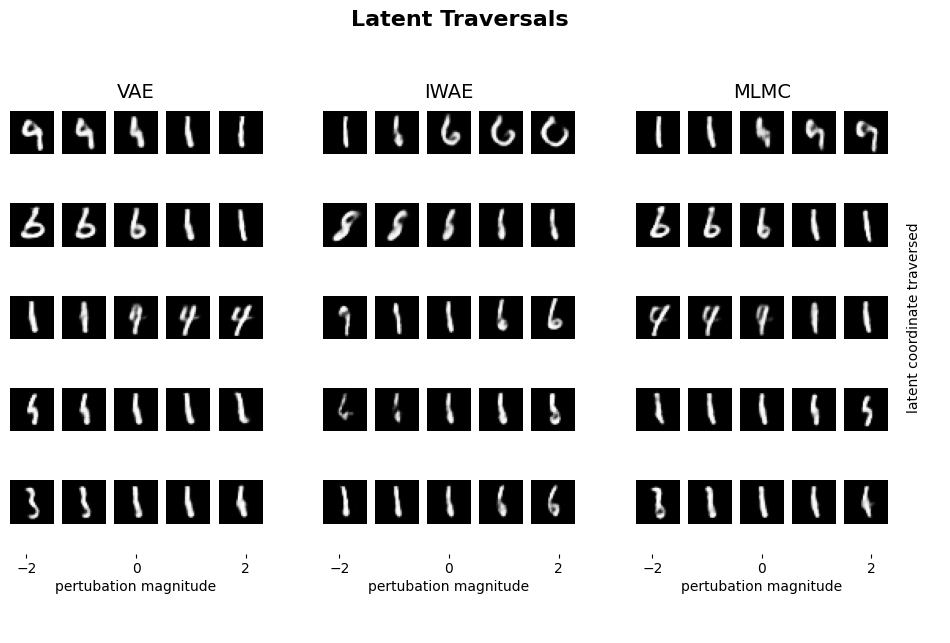

In [48]:
def plot_latent_traversal(vae_model, iwae_model, mlmc_model, dataset, SEED=1):    
    np.random.seed(SEED)
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    vae_model.to(device)
    iwae_model.to(device)
    mlmc_model.to(device)
    
    n_samples = 128
    i_samples = np.random.choice(range(len(dataset)), n_samples, replace=False)
    img_batch = torch.cat([dataset[i].unsqueeze(0) for i in i_samples], 0)
    img_batch = img_batch.to(device)
    # generate latent traversals
    n_pert, pert_min_max, n_lats = 5, 2, 5
    img_trav_vae = vae_model.create_latent_traversal(img_batch, n_pert, pert_min_max, n_lats)
    img_trav_iwae = iwae_model.create_latent_traversal(img_batch, n_pert, pert_min_max, n_lats)
    img_trav_mlmc = mlmc_model.create_latent_traversal(img_batch, n_pert, pert_min_max, n_lats)
    
    fig = plt.figure(figsize=(12, 7))
    n_rows, n_cols = n_lats + 1, 3*n_pert + 2
    gs = GridSpec(n_rows, n_cols + 1)
    plt.suptitle("Latent Traversals", fontsize=16, y=1, fontweight='bold')
    for row_index in range(n_lats):
        for col_index in range(n_pert):
            img_rec_VAE = img_trav_vae[row_index][col_index]
            img_rec_IWAE = img_trav_iwae[row_index][col_index]
            img_rec_MLMC = img_trav_mlmc[row_index][col_index]
            
            ax = plt.subplot(gs[row_index, col_index])
            plt.imshow(img_rec_VAE[0].detach(), cmap='gray', vmin=0, vmax=1)
            plt.axis('off')
            
            if row_index == 0 and col_index == int(n_pert//2):
                plt.title('VAE', fontsize=14, y=1.1)
            
            ax = plt.subplot(gs[row_index, col_index + n_pert + 1])
            plt.imshow(img_rec_IWAE[0].detach(), cmap='gray', vmin=0, vmax=1)
            plt.axis('off')
            if row_index == 0 and col_index == int(n_pert//2):
                plt.title('IWAE', fontsize=14, y=1.1)
            ax = plt.subplot(gs[row_index, col_index + 2*n_pert + 2])
            plt.imshow(img_rec_MLMC[0].detach(), cmap='gray', vmin=0, vmax=1)
            plt.axis('off')
            if row_index == 0 and col_index == int(n_pert//2):
                plt.title('MLMC', fontsize=14, y=1.1)
    # add pertubation magnitude
    for ax in [plt.subplot(gs[n_lats, 0:5]), plt.subplot(gs[n_lats, 6:11]),plt.subplot(gs[n_lats, 12:17])]:
        ax.annotate("pertubation magnitude", xy=(0.5, 0.6), xycoords="axes fraction",
                    va="center", ha="center", fontsize=10)
        ax.set_frame_on(False)
        ax.axes.set_xlim([-1.15 * pert_min_max, 1.15 * pert_min_max])
        ax.xaxis.set_ticks([-pert_min_max, 0, pert_min_max])
        ax.xaxis.set_ticks_position("top")
        ax.xaxis.set_tick_params(direction="inout", pad=-16)
        ax.get_yaxis().set_ticks([])
    # add latent coordinate traversed annotation
    ax = plt.subplot(gs[0:n_rows-1, n_cols])
    ax.annotate("latent coordinate traversed", xy=(0.4, 0.5), xycoords="axes fraction",
                    va="center", ha="center", fontsize=10, rotation=90)
    plt.axis('off')
    return


k = 10
trained_vae = torch.load(f'trained_vae_{k}.pth')
trained_iwae = torch.load(f'trained_iwae_{k}.pth')
trained_mlmc = torch.load(f'trained_mlmc_{k}.pth')
plot_latent_traversal(trained_vae, trained_iwae ,trained_mlmc, test_ds, 4)